In [1]:
import fitz
import uuid
import json
from PIL import Image, ImageDraw
from pathlib import Path
import os
import random
import pandas as pd

In [3]:
doc_path = 'จังหวัดสตูล/เขตเลือกตั้งที่ 02/นอกเขต,นอกราชฯ/ชุดที่ 3/สตูล-03-บัญชีรายชื่อ-นอกเขตนอกราช.pdf'
doc_name = Path(doc_path).name
doc = fitz.Document(doc_path)

In [2]:
def resize_image(pil_image, max_size=1280):
    """
    Resizes an image to 1280 width or height, whichever is larger.
    And keeps the aspect ratio.
    """
    width, height = pil_image.size
    if width > height:
        new_width = max_size
        new_height = int(new_width * height / width)
    else:
        new_height = max_size
        new_width = int(new_height * width / height)
    return pil_image.resize((new_width, new_height))

In [470]:
metainfo = list()
for dirname, dirpaths, filenames in os.walk('จังหวัดสตูล/เขตเลือกตั้งที่ 02/อำเภอละงู/ตำบลละงู'):
    for filename in filenames:
        if not filename.endswith('.pdf'): continue

        doc_path = os.path.join(dirname, filename)

        doc_name = Path(doc_path).name
        doc = fitz.Document(doc_path)
    
        for page in doc.pages():
            for image in page.get_images():
                xref  = image[0]
                pix   = fitz.Pixmap(doc.extract_image(xref)['image'])
                try:
                    image = Image.frombytes('RGB', (pix.width, pix.height), pix.samples)
                except ValueError as e:
                    continue
                hash_val  = hash(pix.samples)
                
                file_name = f'images/{hash_val}.jpg'
                if not os.path.exists(file_name):
                    resize_image(image).save(file_name)
                metainfo.append(dict(doc=doc_path, page_num=page.number, file_name=Path(file_name).name))

In [471]:
pd.DataFrame(metainfo).to_csv('images/metainfo.csv',index=False)

In [410]:
def get_image(doc, xref):
    """
    Gets an image from a PDF document.

    Args:
    doc: A PDF document object.
    xref: The xref of the image to get.

    Returns:
    An Image object representing the image.
    """

    pix = fitz.Pixmap(doc.extract_image(xref)['image'])
    return Image.frombytes('RGB', (pix.width, pix.height), pix.samples)

# Detect table

inference with model on huggingface

In [3]:
from gradio_client import Client

client = Client("https://napatswift-table-det.hf.space/")

Loaded as API: https://napatswift-table-det.hf.space/ ✔


In [4]:
def inference(image_path, client):
    """
    This function performs inference on an image.

    Args:
        image_path: The path to the image file.

    Returns:
        The results of the inference, as a JSON object.
    """

    # Make a prediction using the client.
    result_json_path = client.predict(
        image_path, api_name="/predict")

    # Load the results from the JSON file.
    with open(result_json_path, "r") as fp:
        return json.load(fp)

In [5]:
# Get all image paths
image_fpaths = ['images/'+f for f in os.listdir('images')]

In [ ]:
image_path = random.choice(image_fpaths)
rects = inference(image_path, client)

In [ ]:
image  = Image.open(image_path)
imdraw = ImageDraw.Draw(image)
colours = [(255,0,0),(0,255,0),(0,0,255),(200,0,200)]
random.shuffle(colours)
for i, rect in enumerate(rects['rect-fit']):
    points = [i for p in rect for i in p] + rect[0]
    imdraw.line(points, fill=colours[i%len(colours)], width=4)
    imdraw.rectangle(rects['bbox'][i], outline=colours[(i+1)%len(colours)], width=2)
resize_image(image, 500)

In [8]:
textdet_client = Client("https://napatswift-votecount-ml-be.hf.space/")

Loaded as API: https://napatswift-votecount-ml-be.hf.space/ ✔


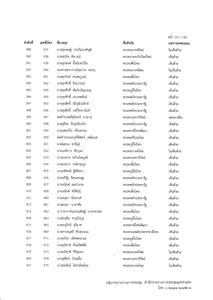

In [9]:
# image_path = random.choice(image_fpaths)
image = Image.open(image_path)
resize_image(image,300)

In [10]:
image_path = \
    '/Users/napatswift/wevis/ocr-vote-log/ds/image/20191021111117A1-12.png'

In [11]:
# image_path = random.choice(image_fpaths)
result = inference(image_path, textdet_client)['predictions'][0]

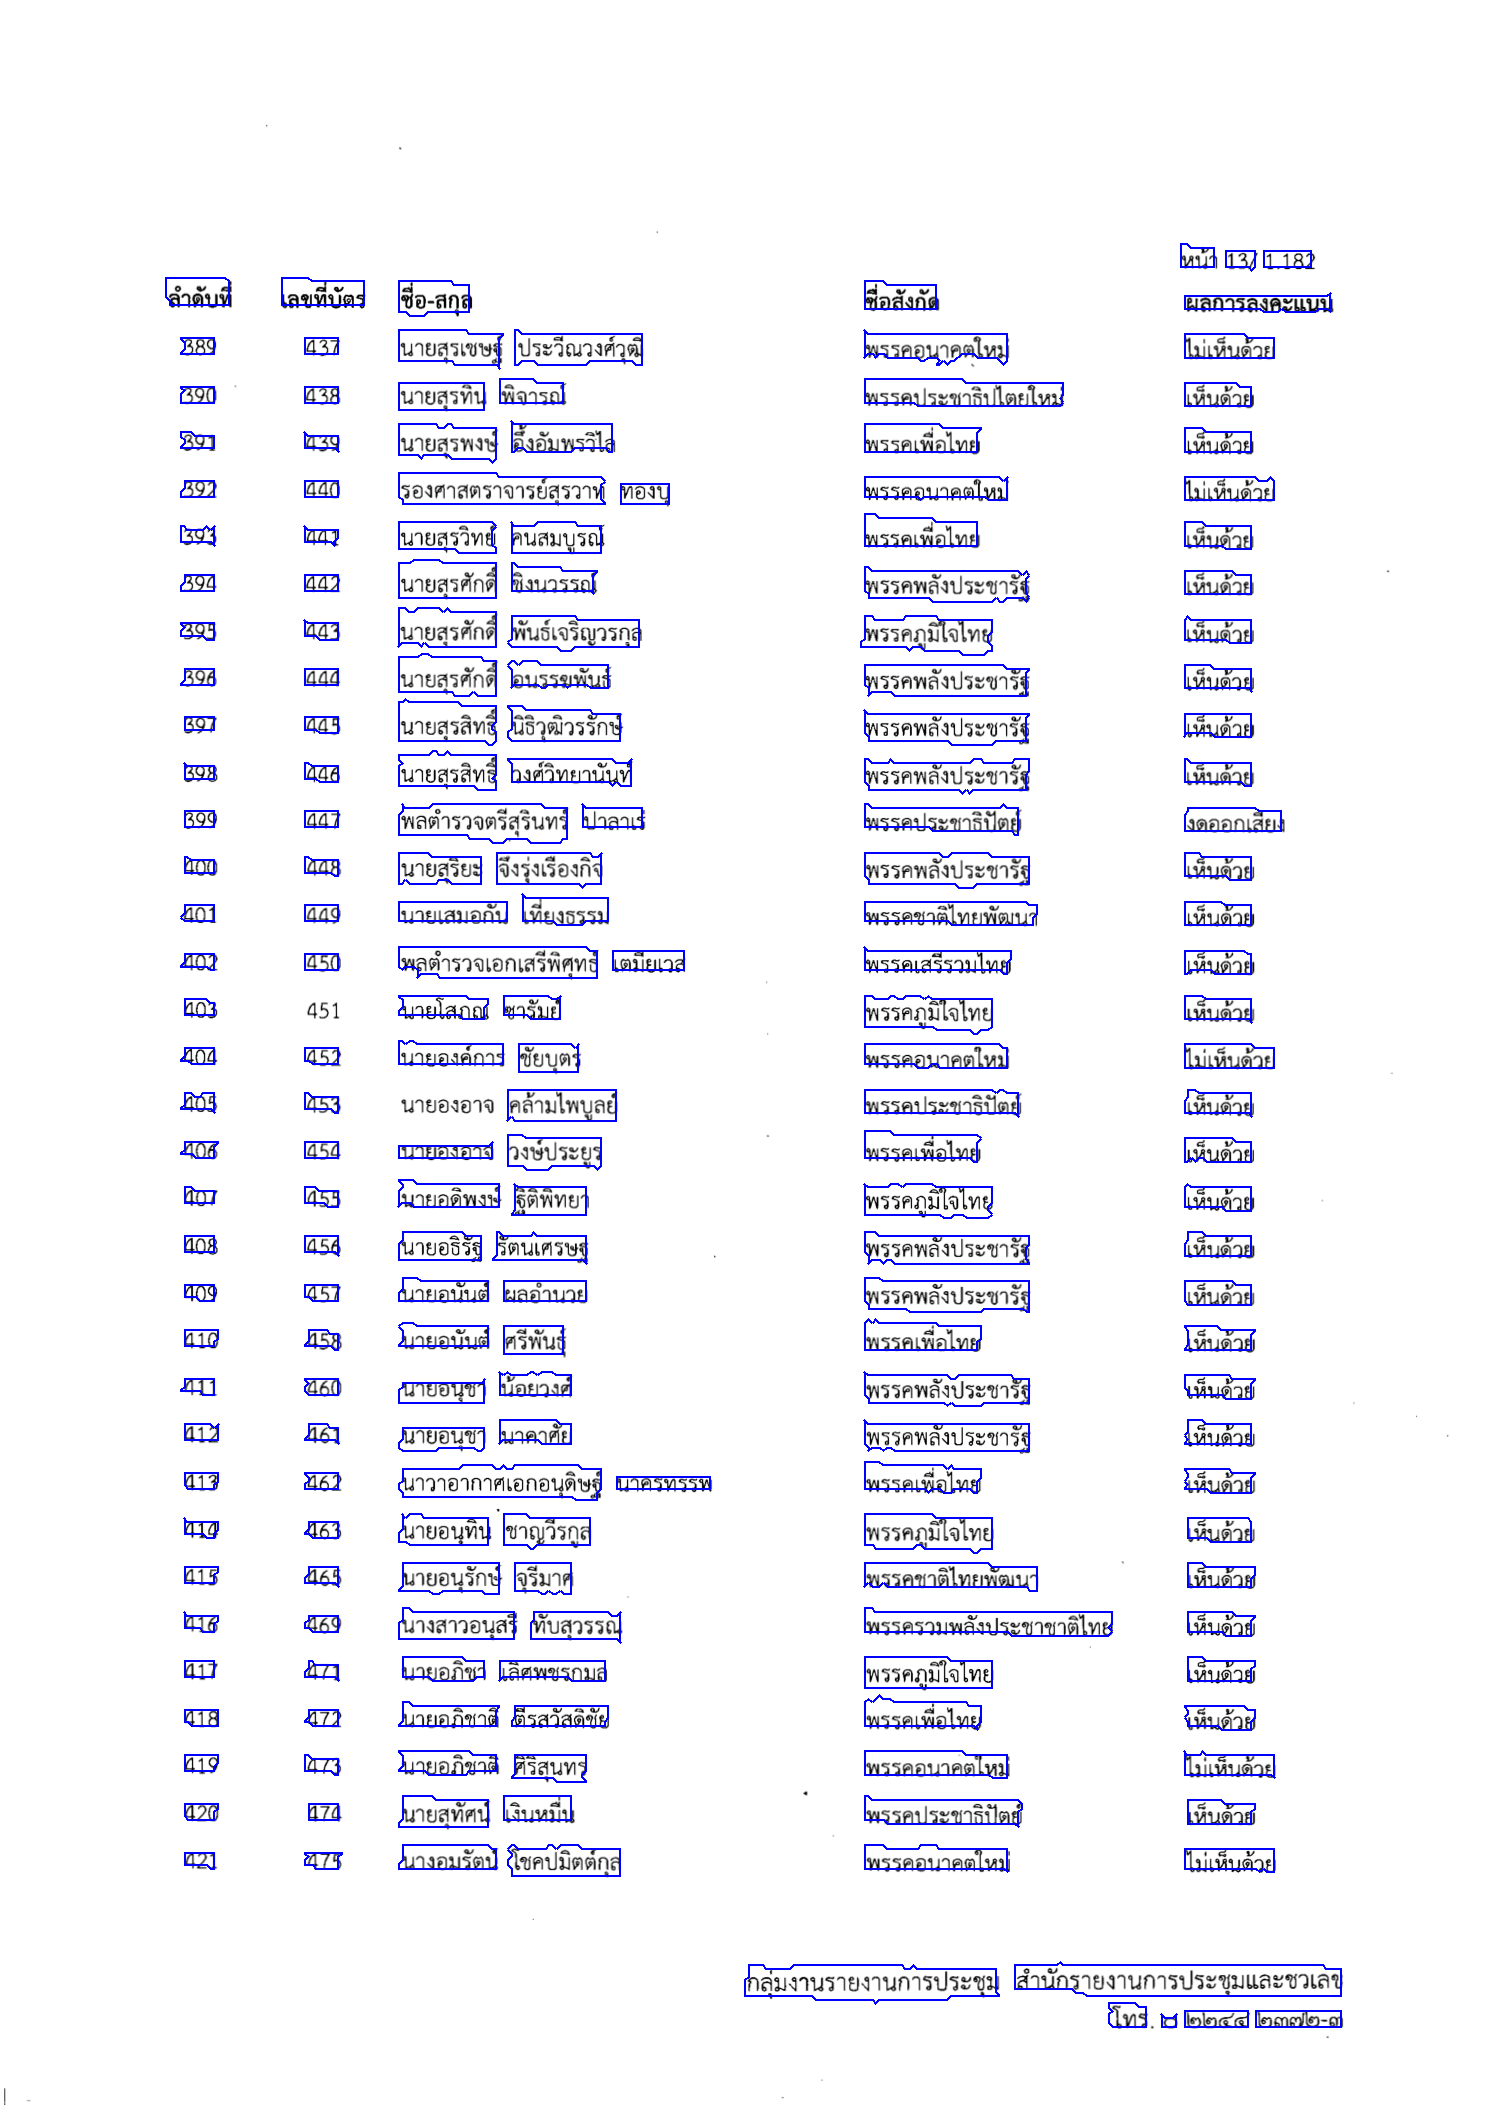

In [12]:
image = Image.open(image_path)
imdraw = ImageDraw.Draw(image)
for i in range(len(result['det_polygons'])):
    # Skip low confident
    if result['det_scores'][i] < 0.9: continue
    imdraw.line(result['det_polygons'][i] + result['det_polygons'][i][:2],
                fill=(0,0,255), width=2)
image